<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [42]:
import re
import string
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import requests
from spacy.tokenizer import Tokenizer
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.neighbors import NearestNeighbors

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
# reading the datasets and converting into daraframe
df = pd.read_csv('./data/job_listings.csv')
print(df.shape)
df.head()
# raise Exception("\nThis task is not complete. \nReplace this line with your code for the task.")
                


(426, 3)


,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [3]:
# Using beautifulSoup to extract html tags from description
soup = BeautifulSoup(df['description'][0])
text = soup.get_text()
df['description'] = [BeautifulSoup(text).get_text() for text in df['description']]
df['description'].head()

0    b"Job Requirements:\nConceptual understanding ...
1    b'Job Description\n\nAs a Data Scientist 1, yo...
2    b'As a Data Scientist you will be working on c...
3    b'$4,969 - $6,756 a monthContractUnder the gen...
4    b'Location: USA \xe2\x80\x93 multiple location...
Name: description, dtype: object

In [4]:
# cleanig out the white space, "b", and "''" from the data
# df['description'] = df['description'].str[1:]
# df['description'] = df['description'].replace({"''":""})
# df['description']
df['description'] = [x[2:] for x in df['description']]
df['description']

0      Job Requirements:\nConceptual understanding in...
1      Job Description\n\nAs a Data Scientist 1, you ...
2      As a Data Scientist you will be working on con...
3      $4,969 - $6,756 a monthContractUnder the gener...
4      Location: USA \xe2\x80\x93 multiple locations\...
                             ...                        
421    About Us:\nWant to be part of a fantastic and ...
422    InternshipAt Uber, we ignite opportunity by se...
423    $200,000 - $350,000 a yearA million people a y...
424    SENIOR DATA SCIENTIST\nJOB DESCRIPTION\n\nABOU...
425    Cerner Intelligence is a new, innovative organ...
Name: description, Length: 426, dtype: object

In [5]:
# using RegEx re.sub() function to replace '\\n' sub-string with "".
df['description'] = df['description'].apply(lambda x : re.sub(r'\\n', "", x))
df['description']

0      Job Requirements:Conceptual understanding in M...
1      Job DescriptionAs a Data Scientist 1, you will...
2      As a Data Scientist you will be working on con...
3      $4,969 - $6,756 a monthContractUnder the gener...
4      Location: USA \xe2\x80\x93 multiple locations2...
                             ...                        
421    About Us:Want to be part of a fantastic and fu...
422    InternshipAt Uber, we ignite opportunity by se...
423    $200,000 - $350,000 a yearA million people a y...
424    SENIOR DATA SCIENTISTJOB DESCRIPTIONABOUT USAm...
425    Cerner Intelligence is a new, innovative organ...
Name: description, Length: 426, dtype: object

In [6]:
df.head()

,Unnamed: 0,description,title
0,0,Job Requirements:Conceptual understanding in M...,Data scientist
1,1,"Job DescriptionAs a Data Scientist 1, you will...",Data Scientist I
2,2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level
3,3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist
4,4,Location: USA \xe2\x80\x93 multiple locations2...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [8]:
# instantiating nlp and the tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [9]:
# creating a tokenizer pipeline
tokens = []

""" Making the description into tokens """
for doc in tokenizer.pipe(df['description'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df['tokens'] = tokens
df['tokens'].head()

0    [Job, Requirements:Conceptual, understanding, ...
1    [Job, DescriptionAs, a, Data, Scientist, 1,, y...
2    [As, a, Data, Scientist, you, will, be, workin...
3    [$4,969, -, $6,756, a, monthContractUnder, the...
4    [Location:, USA, \xe2\x80\x93, multiple, locat...
Name: tokens, dtype: object

In [11]:
df.head()

,Unnamed: 0,description,title,tokens
0,0,Job Requirements:Conceptual understanding in M...,Data scientist,"[Job, Requirements:Conceptual, understanding, ..."
1,1,"Job DescriptionAs a Data Scientist 1, you will...",Data Scientist I,"[Job, DescriptionAs, a, Data, Scientist, 1,, y..."
2,2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[As, a, Data, Scientist, you, will, be, workin..."
3,3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[$4,969, -, $6,756, a, monthContractUnder, the..."
4,4,Location: USA \xe2\x80\x93 multiple locations2...,Data Scientist,"[Location:, USA, \xe2\x80\x93, multiple, locat..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [16]:
# creating transformer for CountVectorizer
vect = CountVectorizer(stop_words='english')

# fitting & creating voabulary
vect.fit(df['description'])
 
# transforming raw data into dtm
dtm = vect.transform(df['description'])

# coverting dtm data into pandas datagrame
dtm =pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [36]:
# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
df['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('and', 11477),
 ('to', 6736),
 ('the', 4931),
 ('of', 4532),
 ('in', 3436),
 ('a', 3393),
 ('with', 2986),
 ('data', 2975),
 ('for', 1972),
 ('or', 1706)]

## 4) Visualize the most common word counts

In [25]:
# getting the words counts from the description column
count = [len(doc) for doc in df['description']]

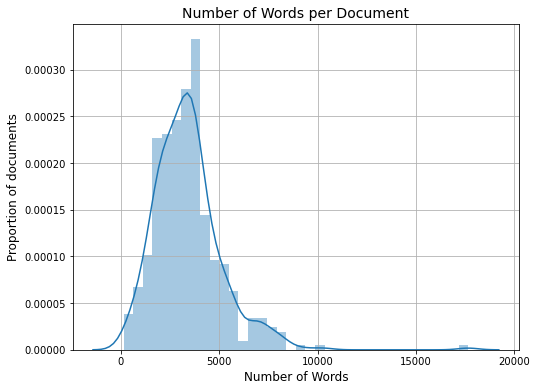

In [29]:
# plotting the most common words distribution
# using the seaborn density plot into a matplotlib figure
plt.figure(figsize=(8,6))
sns.distplot(count)
plt.grid()
plt.title('Number of Words per Document', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Proportion of documents', fontsize=12)
plt.show()



## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [30]:
# defining a function to tokenize documents
def tokenize(document):
    '''Instantiating nlp to learn the document'''
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [31]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df= 0.5, # max data frequency
                        min_df= 3,  # min data frequancy
                        tokenizer=tokenize,
                        max_features = 5000)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['description']) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
print(dtm.shape)
dtm.head()

(426, 5000)


,$,"$ 100,000",+,+ city,+ year,+ years\xe2\x80\x99,0,1,1 year,10,...,you\xe2\x80\x99ll,you\xe2\x80\x99ll develop,you\xe2\x80\x99ll work,you\xe2\x80\x99re,you\xe2\x80\x99re look,you\xe2\x80\x99ve,youyou,yrs,|,||
0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.030831,0.0,0.033665,0.0,0.0,0.116256,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.248879,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.137284,0.0,0.149903,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [43]:
# fitting the dtm on nn

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [45]:
# creating description of my ideal job
text = ['''
Junior
Remote
Data
Analyst
Passionate
Engineering
Programming
''']
# instantiating, and transforming the description
query = tfidf.transform(text)
query

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [47]:
nn.kneighbors(query.todense())

(array([[1.25917929, 1.25917929, 1.27628088, 1.33109957, 1.33388527]]),
 array([[ 23, 123, 256, 173, 203]], dtype=int64))

In [48]:
df['description'][23]

"Motiion is a technology and data company for the food industry. We believe in transparency, diversity, merit and fostering a culture of accountability, personal impact and career growth.As a member of the first product engineering team at Motiion you have will have a unique opportunity to turning previously scattered and inconsistently structured data into directly actionable food industry insights to reduce waste, increase freshness and much more.You have a proven track record of reading data and making solid conclusions. You know both the art and science of analytics - now only do you know how to find answers in the data, you also know which questions should be asked in the first place and what data might could help us further bolster our conclusions. You love engaging with customers, learn about their challenges and then dive into the data to see how to solve them!We are building a product engineering team with a breadth of combined experiences so that we can collaboratively build 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 